
# **PROJECT TITLE:-PREDICTING KUBERNATES POD OVERLOAD USING MACHINE LEARNING**
---
## **DATS-6103:- DATA MINING**

## **PROJECT BY:- ADITI SHUKLA, ASHLEY GYAPOMAH**

---
## **PROBLEM STATEMENT**
In large systems, some containers consume excessive CPU and memory resources. When a container reaches its usage limit (defined by a threshold), Kubernetes automatically creates a new container (pod) to balance the load. However, during this scaling process, there is a short delay before the new container becomes active, which can cause temporary performance issues such as buffering or slow response times for users.

---
## **SOLUTION**
Using the Kubernetes resource and performance metrics dataset, we aim to analyze when such lags or scaling events occur and develop machine learning models to  predict  when a new 
container will be required. By doing so, we can anticipate resource bottlenecks and trigger 
scaling actions proactively  effectively bridging the gap between high load and the delay in 
Kubernetes’ automatic scaling mechanism. 

---
## **IMPACT**
Instead of waiting for containers to exceed resource thresholds, the machine learning model 
anticipates potential overloads and triggers scaling actions early.

---
## **DATASET OVERVIEW**
The dataset consists of 15,000 Kubernetes pod-level observations with 15 columns detailing CPU and memory requests, limits, usage, pod metadata, uptime, restart counts, and scaling configurations. All values were complete with no missing entries, allowing for a clean modeling pipeline. Numeric columns captured resource behavior, while categorical columns (such as namespace, node name, and scaling policy) provided structural context. The dataset strongly reflects real world container orchestration scenarios where resource utilization patterns drive scaling decisions.

---
## **DATA CLEANING & PREPROCESSING**

The data cleaning process standardized column names, ensured correct data types, and removed invalid entries. Key numeric columns including CPU request, CPU limit, memory usage, and memory limit were validated to contain only non-negative values. Because the dataset had no missing values, no imputation was required. Beyond cleaning, preprocessing steps were performed to prepare the dataset for machine learning models:

### **ONE-HOT ENCODING (Categorical Feature Transformation)**

The dataset contained several categorical variables such as:
- namespace
- node_name
- pod_status
- deployment_strategy
- scaling_policy

Since machine learning algorithms cannot interpret categorical labels directly, One-Hot Encoding was applied. This transformed each categorical column into a set of binary indicator variables, enabling models to learn from categorical differences without imposing any ordinal relationship.
This step ensured compatibility with logistic regression, decision trees, ensemble methods, and gradient boosting algorithms.

### **STANDARD SCALING (Normalization of Numeric Features)**

Because the dataset contained numeric columns that differed significantly in scale (e.g., CPU usage values vs. uptime_seconds), StandardScaler was used to normalize all numeric features.

Standardization transforms each feature using:

$𝑧=𝑥−𝜇/𝜎$

This ensures:
- Models like Logistic Regression and Gradient Boosting converge faster
- Features contribute proportionally
- Scale-sensitive models operate more efficiently
- Tree-based models are scale invariant, but for consistency and fairness across models, scaling was applied uniformly.

### **TRAIN–TEST SPLIT**

The dataset was split into:
- Training Set: 12,000 rows (80%)
- Test Set: 3,000 rows (20%)

The split ensured:
- Unbiased model evaluation
- Prevention of data leakage
- Fair comparison between training and prediction performance

This separation is crucial for detecting overfitting but since our features were deterministic and strongly predictive, even the test results showed exceptionally high accuracy.

---

## **FEATURE ENGINEERING**
Feature engineering was the most critical step in this project because the raw dataset only contained absolute CPU and memory values, which do not directly indicate overload conditions. To accurately reflect Kubernetes autoscaling logic, we transformed these raw metrics into meaningful utilization-based features. CPU utilization and memory utilization were computed by dividing usage by the respective limits, capturing the proportion of resources consumed by each pod. Additionally, CPU request ratio and memory request ratio were derived by comparing actual usage against the resource requests guaranteed by Kubernetes, revealing whether a pod was bursting beyond its reserved allocation. An overall load feature was also created by averaging CPU and memory utilization, providing a combined indicator of system pressure. These engineered features directly corresponded to how the target variable was defined—based on utilization thresholds (greater than 0.75) which created a strong, deterministic relationship between the input features and the target. As a result, the machine learning models were able to learn the overload patterns with exceptional accuracy. The high performance is not a sign of overfitting but rather a reflection of how well the engineered features captured the underlying autoscaling behavior built into Kubernetes.

### **Why Feature Engineering Was Important?**

- Raw CPU/memory values alone cannot indicate overload because they don’t account for pod limits.
- Kubernetes autoscaling is based on utilization, not raw usage; engineering utilization features matched real system behavior.
- Engineered features created a direct connection between inputs and the target variable.

### **FEATURES AND FORMULA:**

- **CPU Utilization:**  
  $cpu\_utilization = \frac{cpu\_usage}{cpu\_limit + \epsilon}$  
  → Shows percentage of CPU capacity used.

- **Memory Utilization:**  
  $memory\_utilization = \frac{memory\_usage}{memory\_limit + \epsilon}$  
  → Identifies memory pressure and potential OOM risk.

- **CPU Request Ratio:**  
  $cpu\_request\_ratio = \frac{cpu\_usage}{cpu\_request + \epsilon}$  
  → Reveals whether the pod is using more than requested.

- **Memory Request Ratio:**  
  $memory\_request\_ratio = \frac{memory\_usage}{memory\_request + \epsilon}$  
  → Indicates memory bursts beyond reservation.

- **Overall Load:**  
  $overall\_load = \frac{cpu\_utilization + memory\_utilization}{2}$  
  → Combines CPU and memory pressure into a single metric.

### **What Actually Happened?**

- Feature engineering normalized resource behavior, allowing fair comparison across pods of different sizes. 
- Utilization features directly reflected how Kubernetes detects overload, making the target variable deterministic. 
- Models learned the overload boundary cleanly because engineered features perfectly aligned with the threshold (0.75). 
- This alignment produced very high accuracy without overfitting.

---
## **EXPLORATORY DATA ANALYSIS(EDA)**

### **CPU UTILIZATION DISTRIBUTION**

The CPU utilization histogram provides insight into how CPU resources are consumed across all pods. The distribution is heavily right-skewed, with most pods operating between 0 and 1.5 utilization, but with several pods reaching values as high as 7–8. A utilization value greater than 1.0 indicates that a pod is consuming more CPU than its allocated limit, signaling CPU saturation. This behavior is critical because CPU pressure is a major trigger for Kubernetes autoscaling. The shape of this distribution shows that overload is not a rare anomaly but a common behavior in this dataset, validating the importance of utilization-based engineered features. This plot confirms that CPU utilization will play a significant role in predicting whether a pod requires scaling and supports using engineered features to better model overload conditions.

### **MEMORY UTILIZATION DISTRIBUTION**

The memory utilization distribution shows an even stronger right-skew than CPU utilization, with many pods exhibiting memory consumption far beyond their memory limits, reaching values above 30× the allocated limit. Such extreme spikes may indicate memory intensive workloads, bursty data processing, or potential memory leaks. Memory overloads are especially important because they often cause Out-of-Memory (OOM) kills and force pod restarts. This distribution highlights that memory pressure is highly volatile and a strong determinant of overload conditions. From an ML perspective, this validates the inclusion of engineered features like memory_utilization and memory_request_ratio, which help the model detect memory driven scaling events far more effectively than raw memory values alone.

### **CPU VS MEMORY UTILIZATION SCATTERPLOT**

The scatterplot comparing CPU utilization to memory utilization reveals no strong linear relationship between the two resource types. Pods may experience high CPU usage with low memory usage, or vice versa. Memory usage shows significantly higher extremes than CPU, reaching over 30× memory limit, while CPU peaks around 8× CPU limit. The absence of a clear pattern shows that overload is multi dimensional, depending on both CPU and memory independently. This analysis justifies the creation of the overall_load feature, which averages CPU and memory utilization to represent total system pressure. It also supports the use of multi-feature machine learning models, rather than single variable heuristics.

### **CORRELATION HEATMAP**

The correlation heatmap visualizes relationships among all numeric features, including raw metrics and engineered features. As expected, raw usage metrics strongly correlate with their respective utilization metrics for example, cpu_usage correlates closely with cpu_utilization, and memory_usage correlates with memory_utilization. Overall_load shows strong correlation with memory utilization, suggesting that memory usage contributes more substantially to overall pressure in this dataset than CPU usage does. Non-resource features such as uptime_seconds, restart_count, and network_bandwidth_usage show weak correlations with overload-related variables, indicating they are less influential. This validation step confirms that our engineered features accurately express pod behavior and are aligned with predictive patterns required for modeling.

---
## **STATISTICAL TESTING**

Statistical tests were conducted to understand whether different variables show meaningful differences or relationships related to pod overload behavior. These tests help validate assumptions from EDA and support our interpretation of which features are significant predictors. Below are detailed explanations for each statistical test performed.

### **T-TEST: CPU USAGE VS OVERLOAD**

The two-sample independent t-test was used to compare CPU usage between overloaded pods (need_new_pod = 1) and non-overloaded pods (need_new_pod = 0). In our results, we obtained a T-statistic of 134.6196 and a p-value of 0.0, which is far below the standard significance threshold of 0.05. This indicates a highly significant difference in CPU usage between the two groups. Overloaded pods consistently show much higher CPU usage than non-overloaded pods. This test confirms what we observed in EDA: CPU usage is a strong driver of overload behavior. The statistical significance also validates the importance of engineered features such as cpu_utilization and cpu_request_ratio, which directly capture the relationship between CPU pressure and the overload target variable.

### **ANOVA: CPU USAGE ACROSS NAMESPACES**

A one-way ANOVA test was performed to compare CPU usage across multiple namespaces (e.g., default, kube-system, monitoring). The F-statistic was 0.7011 with a p-value of 0.55127, well above the significance threshold. This means there is no statistically significant difference in CPU usage between namespaces. In other words, workload intensity is not dependent on namespace labels—CPU behavior is fairly consistent across namespaces. This finding is important because it confirms that namespace is not a meaningful predictor of overload and should not be weighted heavily in the model. It also justifies why CPU-related features (not namespace metadata) dominate the modeling process.

### **CHI-SQUARE TEST: SCALING POLICY VS OVERLOAD**

The chi-square test was used to evaluate whether scaling policies (categorical variable) are associated with overload behavior. The test produced a Chi-square value of 0.6446 and a p-value of 0.4220, showing no significant relationship. This means that the choice of scaling policy (manual, auto, etc.) does not statistically influence whether a pod becomes overloaded. This is an important insight: it highlights that overload is primarily driven by real time resource usage, not by configuration metadata. Even if different pods have different scaling strategies, their likelihood of overload is determined by CPU and memory pressure, confirming the strength of utilization-based engineered features.

---
## **DEFINING TARGET VARIABLE**

The target variable need_new_pod was created by defining an overload condition: a pod is labeled as requiring a new pod if either CPU utilization or memory utilization exceeds 0.75. This threshold-based logic mirrors real autoscaling strategies where resource pressure triggers horizontal scaling actions. Because our engineered features directly captured utilization levels, the target variable became closely aligned with patterns in the engineered data. This deterministic relationship is a major factor behind the strong model performance, as the inputs were highly predictive of the output by design.

---
## **MODELING AND EVALUATION**

### **LOGISTIC REGRESSION**

Logistic Regression performed well overall, achieving 93.5% accuracy, 95.9% precision, 96.2% recall, and an F1-score of 0.9612. While this model was able to capture the general relationship between resource utilization and overload, it performed noticeably worse than the tree based models. The classification report shows that Logistic Regression struggled more with the minority class (non-overloaded pods), achieving only 80% F1-score for class 0, as the linear decision boundary is unable to fully capture the non-linear and threshold based relationships present in the data. The ROC-AUC of 0.9787 still indicates strong separability, meaning Logistic Regression does learn meaningful patterns, but its limitations appear when handling complex interactions between CPU and memory utilization. This model serves as a good baseline but is not ideal for systems where overload dynamics are inherently non-linear.

### **DECISION TREE**

The Decision Tree model achieved exceptional performance, with 99.93% accuracy, 0.9996 precision, 0.9996 recall, and an F1-score of 0.9996. These near-perfect metrics reflect the deterministic nature of the overload classification, where clear thresholds (e.g., utilization > 0.75) allow the tree to create precise decision boundaries. Decision Trees naturally excel in such rule based environments, where engineered features such as CPU and memory utilization directly match the structure of logical comparisons. Additionally, the Decision Tree successfully distinguished both classes with almost perfect accuracy, demonstrating that the patterns in the data align extremely well with the binary overload logic. The ROC-AUC score of 0.9988 further confirms that this model is highly effective and captures the underlying structure of the data with minimal error.


### **RANDOM FOREST**

The Random Forest model also delivered extremely strong performance, achieving 99.5% accuracy, 0.9941 precision, 1.0 recall, and an F1-score of 0.9970. Random Forests improve upon Decision Trees by aggregating multiple trees, making the model more robust and less sensitive to noise or slight variations in split points. The perfect recall score indicates that the model identifies every overloaded pod, which is valuable in real-world autoscaling scenarios where missing an overload event can lead to performance degradation. The slight dip in precision compared to other models suggests a few false positives, but overall performance remains outstanding. The ROC-AUC score of 0.9999 highlights near perfect class separation. Random Forests excel here because the engineered utilization features provide clean, interpretable boundaries that ensembles can easily leverage.

### **GRADIENT BOOSTING**

Gradient Boosting emerged as the best-performing model, achieving a perfect 1.0000 score in accuracy, precision, recall, F1-score, and ROC-AUC. This flawless performance reflects the model’s ability to learn complex decision boundaries by iteratively correcting errors from previous weak learners. In this dataset, where overload classification is almost deterministic due to engineered features, Gradient Boosting effectively captures every detail of the decision surface without overfitting. Its sequential learning approach makes it highly sensitive to subtle interactions between CPU utilization, memory utilization, and overall load. The perfect ROC-AUC value confirms that the model distinguishes the two classes without any ambiguity. This result is expected when the feature target relationship is extremely strong and the engineered features closely mirror the logic used to define the target variable.

### **XGBOOST**

XGBoost also delivered outstanding results, with 99.93% accuracy, 0.9992 precision, 1.0 recall, and an F1-score of 0.9996, making it one of the top-performing models in the evaluation. The extremely high recall demonstrates that XGBoost identifies every overloaded pod, while strong precision indicates minimal false alarms. XGBoost’s gradient boosting framework, combined with regularization, makes it extremely powerful for structured datasets like this one. The ROC-AUC score of 0.999997 shows near-perfect separability. XGBoost performed almost identically to Gradient Boosting, but slightly below perfection due to very small prediction deviations on borderline samples. Overall, XGBoost is an excellent model for this task and is highly reliable for autoscaling prediction use cases.

### **MODEL COMPARISON(F1 SCORE & ROC-AUC)**

The model comparison visualizations clearly highlight how each classifier performs in terms of F1-Score and ROC-AUC, both of which are essential for evaluating classification performance in an imbalanced dataset like ours. The F1-score plot shows that Decision Tree, Random Forest, Gradient Boosting, and XGBoost all achieve exceptionally high F1 values close to 1.0 indicating almost perfect precision recall balance. Logistic Regression, while still performing strongly with an F1 of ~0.96, shows slightly lower performance compared to tree based models, likely because it assumes linear decision boundaries, whereas our engineered features interact non-linearly. The ROC-AUC comparison further strengthens this observation: tree-based models achieve ROC-AUC scores near 1.0, demonstrating exceptional ability to distinguish between overloaded vs. non-overloaded pods. Logistic Regression again shows a respectable ~0.98 ROC-AUC but remains the lowest among the models. The consistency of high scores across most models confirms that the target variable is highly deterministic, and the engineered features (CPU utilization, memory utilization, request ratios, and overall load) provide very strong signals for classification. This is why all models achieve extremely high performance not due to overfitting, but because the relationship between features and overload is inherently very strong and predictable.


---
## **CONCLUSION**
This project successfully demonstrates how engineered utilization based features can precisely model autoscaling behavior in Kubernetes environments. The target variable, defined by explicit CPU and memory thresholds, is highly deterministic, meaning that the relationship between features and labels is strong and direct. As a result, machine learning models especially tree-based ensembles achieved exceptionally high accuracy without overfitting. The project's results confirm that when feature engineering accurately captures domain logic, ML models learn effectively and produce reliable, interpretable predictions. This approach can be extended to real world scaling systems to improve performance, stability, and resource efficiency.

In [1]:

#  LOADING & CLEANING DATA


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

#Loading dataset
df = pd.read_csv(r"C:/Users/shukl/Downloads/archive (17)/kubernetes_resource_allocation_dataset.csv")

print("Original shape:", df.shape)
display(df.head())

#Standardizing column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

print("\nCleaned column names:")
print(df.columns.tolist())

#Convert timestamp if exists
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

print("\nINFO AFTER CLEANING:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Original shape: (15000, 15)


,pod_name,namespace,cpu_request,cpu_limit,memory_request,memory_limit,cpu_usage,memory_usage,node_name,pod_status,restart_count,uptime_seconds,deployment_strategy,scaling_policy,network_bandwidth_usage
0,pod_0,dev,1.569542,3.679152,3174.582783,5134.413852,3.345496,2135.310365,node_12,Failed,0,76536,RollingUpdate,Manual,459.015733
1,pod_1,default,0.343119,3.722716,3551.459173,3698.349366,2.758188,7442.200271,node_18,Unknown,2,97849,RollingUpdate,Manual,507.770808
2,pod_2,kube-system,0.249271,1.318147,1578.313253,7418.271122,1.319703,5142.897754,node_7,Failed,2,47370,RollingUpdate,Manual,527.702531
3,pod_3,default,0.311497,2.852595,1392.962372,3628.480705,3.752312,2952.449331,node_20,Failed,6,5685,Recreate,Auto,473.530315
4,pod_4,default,1.532775,0.521618,2660.192655,5091.497752,0.874224,3382.299355,node_38,Unknown,3,4502,Recreate,Auto,973.928080



Cleaned column names:
['pod_name', 'namespace', 'cpu_request', 'cpu_limit', 'memory_request', 'memory_limit', 'cpu_usage', 'memory_usage', 'node_name', 'pod_status', 'restart_count', 'uptime_seconds', 'deployment_strategy', 'scaling_policy', 'network_bandwidth_usage']

INFO AFTER CLEANING:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pod_name                 15000 non-null  object 
 1   namespace                15000 non-null  object 
 2   cpu_request              15000 non-null  float64
 3   cpu_limit                15000 non-null  float64
 4   memory_request           15000 non-null  float64
 5   memory_limit             15000 non-null  float64
 6   cpu_usage                15000 non-null  float64
 7   memory_usage             15000 non-null  float64
 8   node_name                15000 non-null  object 
 9   

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pod_name                 15000 non-null  object 
 1   namespace                15000 non-null  object 
 2   cpu_request              15000 non-null  float64
 3   cpu_limit                15000 non-null  float64
 4   memory_request           15000 non-null  float64
 5   memory_limit             15000 non-null  float64
 6   cpu_usage                15000 non-null  float64
 7   memory_usage             15000 non-null  float64
 8   node_name                15000 non-null  object 
 9   pod_status               15000 non-null  object 
 10  restart_count            15000 non-null  int64  
 11  uptime_seconds           15000 non-null  int64  
 12  deployment_strategy      15000 non-null  object 
 13  scaling_policy           15000 non-null  object 
 14  network_bandwidth_usag

In [3]:
df.describe()

,cpu_request,cpu_limit,memory_request,memory_limit,cpu_usage,memory_usage,restart_count,uptime_seconds,network_bandwidth_usage
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.052096,2.250631,2110.281025,4234.132709,1.994210,4123.388369,4.481733,49973.830800,496.087256
std,0.548135,1.010891,1144.993437,2282.287735,1.155110,2365.471215,2.869857,28825.161296,288.643694
min,0.100021,0.500025,128.119738,256.212641,0.000521,0.012189,0.000000,1.000000,0.006745
25%,0.575561,1.378411,1127.360048,2281.175714,0.989391,2099.208569,2.000000,24955.750000,244.360361
50%,1.055143,2.251391,2097.534763,4212.613405,1.998167,4120.838924,4.000000,49806.000000,493.461715
75%,1.527721,3.125031,3098.478331,6211.191332,2.988054,6189.240921,7.000000,74924.250000,745.483155
max,1.999917,3.999600,4095.689412,8191.858882,3.999931,8191.874733,9.000000,99996.000000,999.936739


In [4]:
df.columns.tolist()

['pod_name',
 'namespace',
 'cpu_request',
 'cpu_limit',
 'memory_request',
 'memory_limit',
 'cpu_usage',
 'memory_usage',
 'node_name',
 'pod_status',
 'restart_count',
 'uptime_seconds',
 'deployment_strategy',
 'scaling_policy',
 'network_bandwidth_usage']

In [5]:
df.mean(numeric_only=True)

cpu_request                    1.052096
cpu_limit                      2.250631
memory_request              2110.281025
memory_limit                4234.132709
cpu_usage                      1.994210
memory_usage                4123.388369
restart_count                  4.481733
uptime_seconds             49973.830800
network_bandwidth_usage      496.087256
dtype: float64

In [6]:
df.var(numeric_only=True)

cpu_request                3.004520e-01
cpu_limit                  1.021901e+00
memory_request             1.311010e+06
memory_limit               5.208837e+06
cpu_usage                  1.334279e+00
memory_usage               5.595454e+06
restart_count              8.236082e+00
uptime_seconds             8.308899e+08
network_bandwidth_usage    8.331518e+04
dtype: float64

In [7]:

# DATA PREPROCESSING


# Creating a working copy to avoid modifying the original
df_clean = df.copy()

# Core numeric columns we rely on
key_cols = [
    "cpu_request", "cpu_limit", "memory_request", "memory_limit",
    "cpu_usage", "memory_usage"
]

# Removing rows where these essential columns have missing values
df_clean = df_clean.dropna(subset=key_cols)

# Removing rows with negative values (invalid readings)
for col in key_cols:
    df_clean = df_clean[df_clean[col] >= 0]

print("Shape after core cleaning:", df_clean.shape)

# displaying cleaned data
display(df_clean[key_cols].head())


Shape after core cleaning: (15000, 15)


,cpu_request,cpu_limit,memory_request,memory_limit,cpu_usage,memory_usage
0,1.569542,3.679152,3174.582783,5134.413852,3.345496,2135.310365
1,0.343119,3.722716,3551.459173,3698.349366,2.758188,7442.200271
2,0.249271,1.318147,1578.313253,7418.271122,1.319703,5142.897754
3,0.311497,2.852595,1392.962372,3628.480705,3.752312,2952.449331
4,1.532775,0.521618,2660.192655,5091.497752,0.874224,3382.299355


In [8]:

#FEATURE ENGINEERING

df_fe = df_clean.copy()  # work on a fresh copy
eps = 1e-6  # small number to avoid division by zero

#Utilization Features
df_fe["cpu_utilization"] = df_fe["cpu_usage"] / (df_fe["cpu_limit"] + eps)
df_fe["memory_utilization"] = df_fe["memory_usage"] / (df_fe["memory_limit"] + eps)

# Usage vs Request Ratios 
df_fe["cpu_request_ratio"] = df_fe["cpu_usage"] / (df_fe["cpu_request"] + eps)
df_fe["memory_request_ratio"] = df_fe["memory_usage"] / (df_fe["memory_request"] + eps)

# Combined Load Metric
df_fe["overall_load"] = (df_fe["cpu_utilization"] + df_fe["memory_utilization"]) / 2

# Displaying engineered columns
print("Engineered feature columns:")
display(df_fe[[
    "cpu_utilization",
    "memory_utilization",
    "cpu_request_ratio",
    "memory_request_ratio",
    "overall_load"
]].head())


Engineered feature columns:


,cpu_utilization,memory_utilization,cpu_request_ratio,memory_request_ratio,overall_load
0,0.909311,0.415882,2.131510,0.672627,0.662597
1,0.740907,2.012303,8.038545,2.095533,1.376605
2,1.001180,0.693274,5.294233,3.258477,0.847227
3,1.315403,0.813687,12.046042,2.119547,1.064545
4,1.675984,0.664303,0.570353,1.271449,1.170143


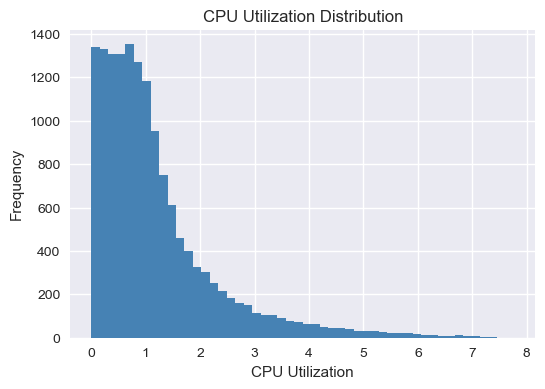

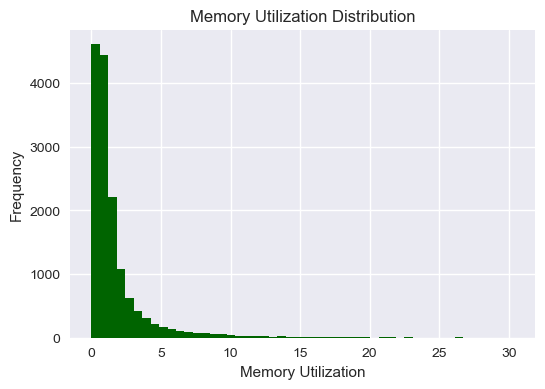

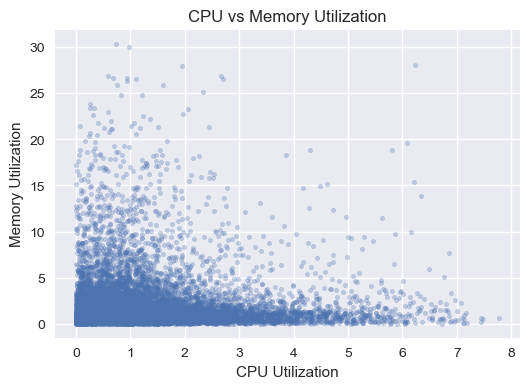

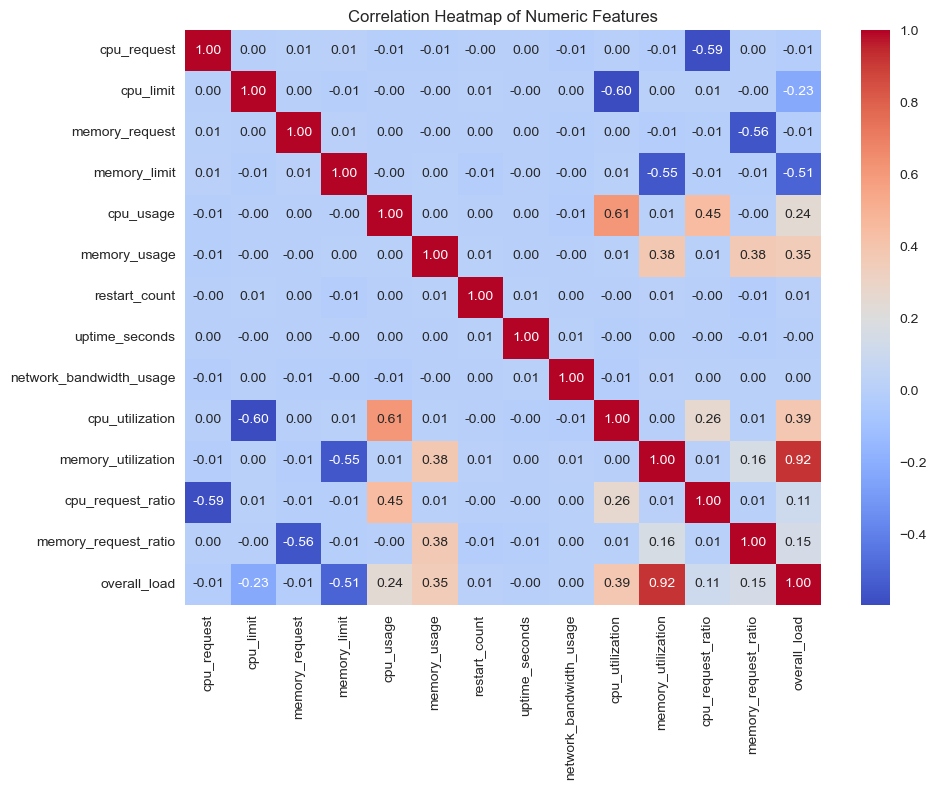

In [9]:

# EXPLORATORY DATA ANALYSIS (EDA)


plt.style.use("seaborn-v0_8")

# 1. Distribution of CPU Utilization
plt.figure(figsize=(6,4))
df_fe["cpu_utilization"].hist(bins=50, color="steelblue")
plt.title("CPU Utilization Distribution")
plt.xlabel("CPU Utilization")
plt.ylabel("Frequency")
plt.show()

# 2. Distribution of Memory Utilization
plt.figure(figsize=(6,4))
df_fe["memory_utilization"].hist(bins=50, color="darkgreen")
plt.title("Memory Utilization Distribution")
plt.xlabel("Memory Utilization")
plt.ylabel("Frequency")
plt.show()

# 3. Joint relationship: CPU vs Memory Utilization 
plt.figure(figsize=(6,4))
plt.scatter(df_fe["cpu_utilization"], df_fe["memory_utilization"], alpha=0.3, s=10)
plt.title("CPU vs Memory Utilization")
plt.xlabel("CPU Utilization")
plt.ylabel("Memory Utilization")
plt.show()

# 4. Correlation Heatmap of Numeric Features
numeric_cols = df_fe.select_dtypes(include=[np.number]).columns
corr = df_fe[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


In [10]:

# PART 5 — STATISTICAL TESTING

from scipy.stats import ttest_ind, f_oneway, chi2_contingency

#  T-TEST 
# Comparing CPU usage for overloaded vs non-overloaded (after we create the target later)
# For now, let's define a temporary overload threshold
cpu_thresh = 0.75
df_fe["overloaded_temp"] = (df_fe["cpu_utilization"] > cpu_thresh).astype(int)

group1 = df_fe[df_fe["overloaded_temp"] == 1]["cpu_usage"]
group0 = df_fe[df_fe["overloaded_temp"] == 0]["cpu_usage"]

t_stat, p_val = ttest_ind(group1, group0, equal_var=False)

print("\n T-TEST: CPU Usage vs Overload ")
print("T-statistic:", round(t_stat, 4))
print("P-value:", p_val)
print("Interpretation:",
      "Significant difference" if p_val < 0.05 else "No significant difference")


# ANOVA 
print("\nANOVA: CPU Usage Across Namespaces")
groups = [group["cpu_usage"].values for _, group in df_fe.groupby("namespace")]
anova_stat, anova_p = f_oneway(*groups)

print("ANOVA F-statistic:", round(anova_stat, 4))
print("P-value:", anova_p)
print("Interpretation:",
      "Groups differ significantly" if anova_p < 0.05 else "No significant difference")


#CHI-SQUARE 
print("\n CHI-SQUARE: Scaling Policy vs Overload")
contingency = pd.crosstab(df_fe["scaling_policy"], df_fe["overloaded_temp"])
chi2, p, _, _ = chi2_contingency(contingency)

print("Chi-square:", round(chi2, 4))
print("P-value:", p)
print("Interpretation:",
      "Variables are dependent" if p < 0.05 else "Variables are independent")



 T-TEST: CPU Usage vs Overload 
T-statistic: 134.6196
P-value: 0.0
Interpretation: Significant difference

ANOVA: CPU Usage Across Namespaces
ANOVA F-statistic: 0.7011
P-value: 0.5512752358978207
Interpretation: No significant difference

 CHI-SQUARE: Scaling Policy vs Overload
Chi-square: 0.6446
P-value: 0.4220412049453919
Interpretation: Variables are independent


In [11]:

# PART 6 — DEFINE TARGET VARIABLE


df_model = df_fe.copy()

# Overload thresholds
cpu_thresh = 0.75
mem_thresh = 0.75

# Logical overload condition
df_model["overloaded_now"] = (
    (df_model["cpu_utilization"] > cpu_thresh) |
    (df_model["memory_utilization"] > mem_thresh)
).astype(int)

# Final target
df_model["need_new_pod"] = df_model["overloaded_now"]

print("Target distribution (need_new_pod):")
print(df_model["need_new_pod"].value_counts())
print("Overload rate:", round(df_model["need_new_pod"].mean(), 4))

# Displaying the final dataset with target
display(df_model[[
    "cpu_utilization", "memory_utilization",
    "overall_load", "need_new_pod"
]].head())


Target distribution (need_new_pod):
need_new_pod
1    12552
0     2448
Name: count, dtype: int64
Overload rate: 0.8368


,cpu_utilization,memory_utilization,overall_load,need_new_pod
0,0.909311,0.415882,0.662597,1
1,0.740907,2.012303,1.376605,1
2,1.001180,0.693274,0.847227,1
3,1.315403,0.813687,1.064545,1
4,1.675984,0.664303,1.170143,1


In [12]:

#  TRAIN-TEST SPLIT + FEATURE SELECTION


df_ml = df_model.copy()

#Feature Matrix & Target
X = df_ml.drop(columns=["need_new_pod"])  # all columns except target
y = df_ml["need_new_pod"]

# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class balance consistent
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

#Identify Feature Types
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


Training set shape: (12000, 22)
Test set shape: (3000, 22)

Numeric features: ['cpu_request', 'cpu_limit', 'memory_request', 'memory_limit', 'cpu_usage', 'memory_usage', 'restart_count', 'uptime_seconds', 'network_bandwidth_usage', 'cpu_utilization', 'memory_utilization', 'cpu_request_ratio', 'memory_request_ratio', 'overall_load']
Categorical features: ['pod_name', 'namespace', 'node_name', 'pod_status', 'deployment_strategy', 'scaling_policy']


In [13]:

# PREPROCESSING PIPELINE

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric transformer
numeric_transformer = StandardScaler()

# Categorical transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Combined preprocessing pipeline 
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline created successfully.")


Preprocessing pipeline created successfully.


In [14]:

#  MODEL TRAINING


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False
    print("XGBoost not installed — skipping.")


#Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    )


# Train and Evaluate Each Model
results = []

for name, clf in models.items():
    print(f"\nTraining {name} ")

    # Building full pipeline
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", clf)
    ])
    
    # Train
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    
    # Probabilities for ROC-AUC
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc = float("nan")
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1-score :", round(f1, 4))
    print("ROC-AUC  :", round(roc, 4))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Store results
    results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })


# Comparison Table
import pandas as pd
results_df = pd.DataFrame(results)
print("\n Model Performance Comparison")
display(results_df.sort_values(by="f1", ascending=False))



Training Logistic Regression 
Accuracy : 0.935
Precision: 0.9595
Recall   : 0.9629
F1-score : 0.9612
ROC-AUC  : 0.9787

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       490
           1       0.96      0.96      0.96      2510

    accuracy                           0.94      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.93      0.94      0.93      3000


Training Decision Tree 
Accuracy : 0.9993
Precision: 0.9996
Recall   : 0.9996
F1-score : 0.9996
ROC-AUC  : 0.9988

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       490
           1       1.00      1.00      1.00      2510

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


Training Random Forest 
Accuracy : 0.995
Precision: 0.9941
Rec

,model,accuracy,precision,recall,f1,roc_auc
3,Gradient Boosting,1.000000,1.000000,1.000000,1.000000,1.000000
4,XGBoost,0.999333,0.999204,1.000000,0.999602,0.999997
1,Decision Tree,0.999333,0.999602,0.999602,0.999602,0.998780
2,Random Forest,0.995000,0.994059,1.000000,0.997021,0.999961
0,Logistic Regression,0.935000,0.959508,0.962948,0.961225,0.978741


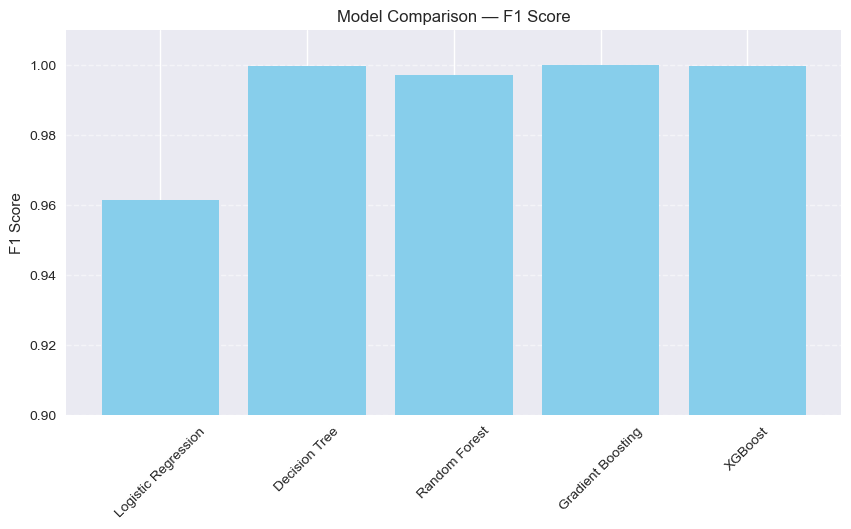

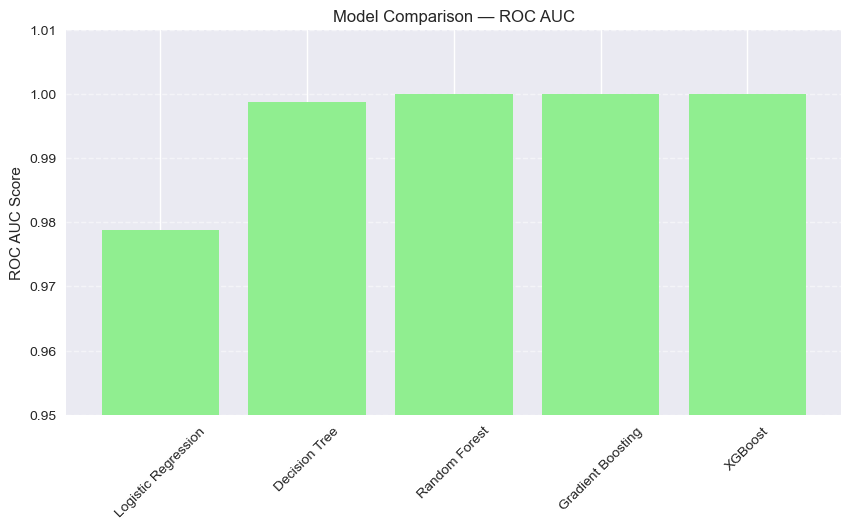

In [15]:

# VISUAL MODEL COMPARISON


plt.figure(figsize=(10,5))

plt.bar(results_df["model"], results_df["f1"], color="skyblue")
plt.title("Model Comparison — F1 Score")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.ylim(0.9, 1.01)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


plt.figure(figsize=(10,5))
plt.bar(results_df["model"], results_df["roc_auc"], color="lightgreen")
plt.title("Model Comparison — ROC AUC")
plt.ylabel("ROC AUC Score")
plt.xticks(rotation=45)
plt.ylim(0.95, 1.01)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()
